# Testing - scents grid w/ noise - 9

WSLS, on the grid

In [1]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import explorationlib
from explorationlib.local_gym import ScentGrid

from explorationlib.agent import WSLSGrid
from explorationlib.agent import CriticGrid
from explorationlib.agent import SoftmaxActor
from explorationlib.agent import DiffusionGrid
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import AccumulatorInfoGrid

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import add_noise
from explorationlib.local_gym import create_grid_scent_patches

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid
from explorationlib.plot import plot_targets2d

from explorationlib.score import total_reward
from explorationlib.score import num_death

pygame 2.0.1 (SDL 2.0.14, Python 3.6.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Uncomment for local development
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

# Shared params, env, and agents

In [3]:
# Noise and delete
p_scent = 0.1
noise_sigma = 2.0

# Shared 
num_experiments = 100
num_steps = 200
seed_value = 5838

# ! (leave alone)
detection_radius = 1
cog_mult = 1
max_steps = 1
min_length = 1
num_targets = 20
target_boundary = (10, 10)

# Targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

<IPython.core.display.Javascript object>

In [4]:
possible_actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
num_action = len(possible_actions)
initial_bins = np.linspace(0, 1, 10)

critic_R = CriticGrid(default_value=0.5)
critic_E = CriticGrid(default_value=np.log(num_action))
actor_R = SoftmaxActor(num_actions=4, actions=possible_actions, beta=20) # Eff det.
actor_E = SoftmaxActor(num_actions=4, actions=possible_actions, beta=20)

wsls = WSLSGrid(
    actor_E,
    critic_E,
    actor_R,
    critic_R,
    initial_bins,
    lr=0.1,
    gamma=0.1,
    boredom=0.0
)

# !
wsls_exp = experiment(
    f"wsls",
    wsls,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

wsls: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


<IPython.core.display.Javascript object>

## Value traces
First and last

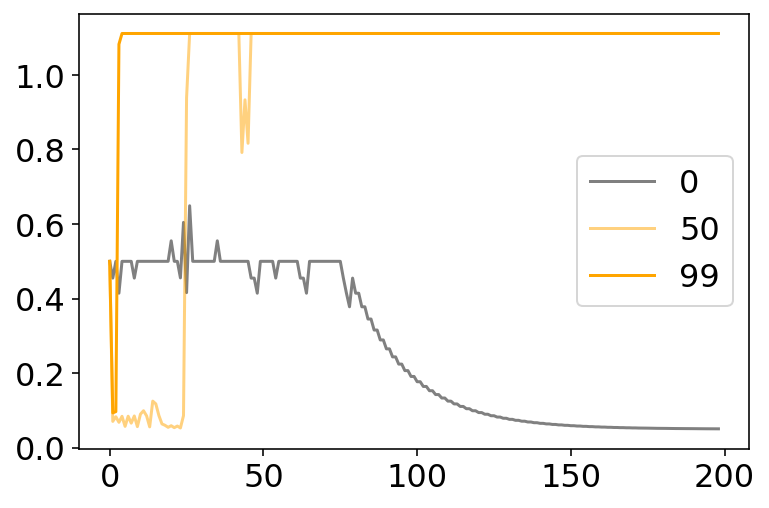

<IPython.core.display.Javascript object>

In [5]:
plt.plot(wsls_exp[0]["agent_reward_value"], label="0", color="grey")
plt.plot(wsls_exp[50]["agent_reward_value"], label="50", color="orange", alpha=0.5)
plt.plot(wsls_exp[98]["agent_reward_value"], label="99", color="orange", alpha=1)
plt.legend()

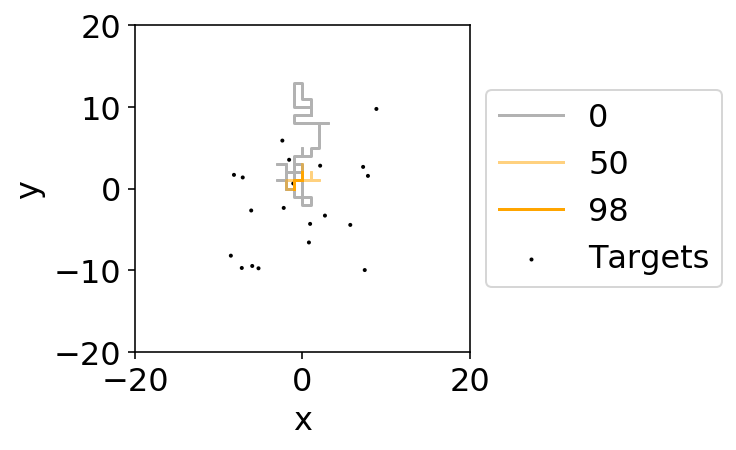

<IPython.core.display.Javascript object>

In [6]:
# rl_exp[0]["exp_agent"].critic.model.values()
plot_boundary = (20, 20)

# -
num_experiment = 0
ax = None
ax = plot_position2d(
    select_exp(wsls_exp, num_experiment),
    boundary=plot_boundary,
    label=f"{num_experiment}",
    color="grey",
    alpha=0.6,
    ax=ax,
)
num_experiment = 50
ax = plot_position2d(
    select_exp(wsls_exp, num_experiment),
    boundary=plot_boundary,
    label=f"{num_experiment}",
    color="orange",
    alpha=0.5,
    ax=ax,
)
num_experiment = 98
ax = plot_position2d(
    select_exp(wsls_exp, num_experiment),
    boundary=plot_boundary,
    label=f"{num_experiment}",
    color="orange",
    alpha=1,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

In [7]:

# Agents
diff = DiffusionGrid(min_length=min_length, scale=1)
diff.seed(seed_value)

chemo = AccumulatorGradientGrid(
    min_length=min_length, 
    max_steps=max_steps, 
    drift_rate=1, 
    threshold=3,
    accumulate_sigma=1
)
chemo.seed(seed_value)

info = AccumulatorInfoGrid(
    min_length=min_length, 
    max_steps=max_steps, 
    drift_rate=1, 
    threshold=3,
    accumulate_sigma=1
)
info.seed(seed_value)

# !
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps * cog_mult,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps * cog_mult,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

info: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


<IPython.core.display.Javascript object>

num_death: 100%|██████████| 100/100 [00:00<00:00, 21756.95it/s]


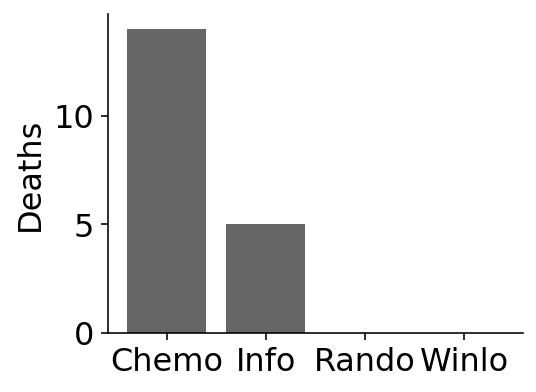

<IPython.core.display.Javascript object>

In [8]:
# Results
results = [chemo_exp, info_exp, rand_exp, wsls_exp]
names = ["Chemo", "Info", "Rando", "Winlo"]
colors = ["blue", "green", "grey", "orange"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

total_reward: 100%|██████████| 100/100 [00:00<00:00, 3557.81it/s]


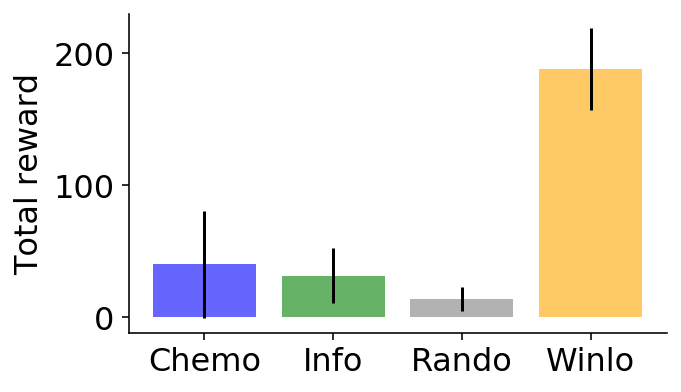

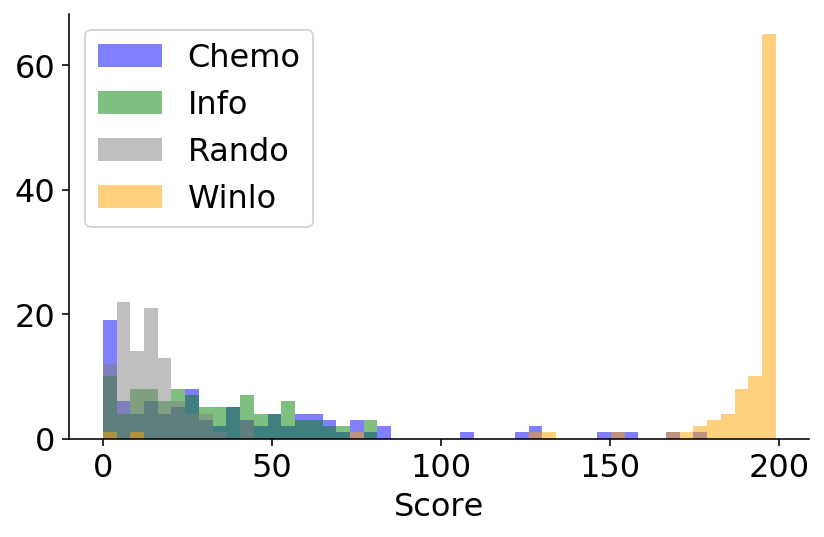

<IPython.core.display.Javascript object>

In [9]:
# Results
results = [chemo_exp, info_exp, rand_exp, wsls_exp]
names = ["Chemo", "Info", "Rando", "Winlo"]
colors = ["blue", "green", "grey", "orange"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(6, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

In [10]:
print(m)

[39.85, 31.18, 13.63, 187.9]


<IPython.core.display.Javascript object>